In [1]:
## TODO
## subclass nx.graph and store adj, D, etc as attribute variables
## Grabriel quality

In [2]:
## custom
import itertools
import math
import os
import pickle as pkl

## sys
import random
import time
from collections import defaultdict
from glob import glob
from pathlib import Path

import matplotlib.animation as animation

## vis
import matplotlib.pyplot as plt

## third party
import networkx as nx

## numeric
import numpy as np
import scipy.io as io
import torch
import torch.nn.functional as F

## notebook
from IPython import display
from IPython.display import clear_output
from matplotlib import collections as mc
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from natsort import natsorted
from PIL import Image
from torch import nn, optim
from tqdm.notebook import tqdm

import criteria as C
import gd2
import quality as Q
from utils import poly_point_isect as bo  # #bentley-ottmann sweep line
from utils import utils, vis

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = "cpu"
plt.style.use("ggplot")
plt.style.use("seaborn-colorblind")

/tmp/ipykernel_29050/447047424.py:50: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


## Example matrix

## training

In [3]:
##choose a graph


# G = nx.balanced_tree(2,5)
# graph_str = 'tree_2_5'

G = nx.grid_2d_graph(6, 10)
graph_str = "grid_6_10"


start_date = int(time.time())
dir_out = f"./analysis/criteria_pairs/{graph_str}-t{start_date}"
print(dir_out)
if not Path(dir_out).exists():
    os.makedirs(dir_out)

./analysis/criteria_pairs/grid_6_10-t1727474743


In [4]:
dir_out

'./analysis/criteria_pairs/grid_6_10-t1727474743'

In [5]:
##TODO
## redoing angular resolution

# G = nx.balanced_tree(2,5)
# graph_str = 'tree_2_5'
# dir_out = './analysis/criteria_pairs/tree_2_5-t1636413236'

G = nx.grid_2d_graph(6, 10)
graph_str = "grid_6_10"
dir_out = "./analysis/criteria_pairs/grid_6_10-t1636413141"

In [13]:
# %%time


# import importlib
# importlib.reload(C)
# importlib.reload(Q)
# importlib.reload(utils)
# importlib.reload(vis)
# import gd2
# importlib.reload(gd2)
# from gd2 import GD2


criteria_weights = dict(
    stress=1,
    ideal_edge_length=0.05,
    neighborhood_preservation=0.5,
    crossings=0.2,
    crossing_angle_maximization=0.1,
    aspect_ratio=3,
    angular_resolution=1,
    vertex_resolution=1,
    gabriel=0.1,
)

sample_sizes = dict(
    stress=32,
    ideal_edge_length=32,
    neighborhood_preservation=16,
    crossings=128,
    crossing_angle_maximization=16,
    aspect_ratio=max(128, int(len(G)**0.5)),
    angular_resolution=128,
    vertex_resolution=max(256, int(len(G)**0.5)),
    gabriel=64,
)


# ## choose criteria
# criteria_all = [
#     'stress',
#     'ideal_edge_length',
#     'neighborhood_preservation',
#     'crossings',
#     'crossing_angle_maximization',
#     'aspect_ratio',
#     'angular_resolution',
#     'vertex_resolution',
#     'gabriel',
# ]

# criteria_pairs = [
#     (ci, cj) for (i,ci), (j, cj)
#     in list(
#         itertools.product(
#             enumerate(criteria_all),
#             enumerate(criteria_all)
#         ))
# #     if i<=j
#     if i<=j and 'angular_resolution' in (ci,cj)
# ]


# for ci, cj in tqdm(criteria_pairs):
#     criteria_pair = {ci, cj}
#     print(criteria_pair)

#     seed = 2337
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)

#     gd = GD2(G)

#     result = gd.optimize(
#         criteria_weights={c:criteria_weights[c] for c in criteria_pair},
#         sample_sizes=sample_sizes,
#         evaluate=criteria_all,

#         max_iter=40000,
#         evaluate_interval=40000//40,
#         vis_interval=-40000//10,
# #             clear_output=True,
#         criteria_kwargs = dict(
#             aspect_ratio=dict(target=[1,1]),
#         ),
# #         optimizer_kwargs = dict(mode='Adam', lr=0.005),
#         optimizer_kwargs = dict(mode='SGD', lr=2),
#         scheduler_kwargs = dict(verbose=False),
#     )
#     print(result['qualities'])

#     pos = gd.pos.detach().numpy()
#     pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
#     vis.plot(
#         gd.G, pos_G,
#         gd.loss_curve,
#         result['iter'], result['runtime'],
#         show=True, save=False
#     )


#     ## store data
#     if ci == cj:
#         fn = ci
#     else:
#         fn = f'{ci}-vs-{cj}'
#     gd.save(f'{dir_out}/{fn}.pkl')

## plot examples in a matrix

In [14]:
import importlib

importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2

importlib.reload(gd2)
from gd2 import GD2

In [15]:
def show_text(ax, text):
    plt.text(0, 0, f"{text}", fontsize="x-large", ha="center", va="center")
    ax.set_facecolor("white")
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.xticks([])
    plt.yticks([])

In [16]:
def draw_graph(data, ax):
    ## draw graphs
    pos = data["pos"].detach().numpy()
    pos_G = {k: pos[data["k2i"][k]] for k in data["G"].nodes}
    vis.draw_graph(
        data["G"],
        pos_G,
        ax=ax,
        #                     ylabel=ci,# if j==0 else '',
        #                     xlabel=cj,# if i==0 else '',
    )
    ax.xaxis.set_label_position("top")
    plt.axis("equal")
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


def draw_scatter_plot(data, ci, cj):
    if ci == cj == "":
        return
    elif ci == "" and cj != "":
        ci = cj
    elif cj == "" and ci != "":
        cj = ci

    ## plot learn curves
    t = [r["time"] for r in data["qualities_by_time"]]
    quality_curve_x = [r["qualities"][cj] for r in data["qualities_by_time"]]
    quality_curve_y = [r["qualities"][ci] for r in data["qualities_by_time"]]
    plt.scatter(quality_curve_x, quality_curve_y, s=50, c=t)
    plt.plot(quality_curve_x, quality_curve_y, c="#777", zorder=-1)
    plt.xlabel(cj)
    plt.ylabel(ci)


def draw_learning_curve(data, data1, data2, ci, cj, ylim=None, bg_color=True):
    ## plot quality curves
    t = [r["time"] for r in data["qualities_by_time"]]

    ## learning curve of single criterion
    if ci == "" or cj == "":
        c = max(ci, cj)
        quality_curve = np.array([r["qualities"][c] for r in data["qualities_by_time"]])
        if c in {"stress", "crossings", "ideal_edge_length"}:
            quality_curve = quality_curve / quality_curve.max()

        plt.plot(
            t,
            quality_curve,
            "--",
            label=f"{utils.criterion_to_title(c)} - single",
            lw=2.0,
            color="C0" if i > j else "C1",
        )

    ## learning curves of a pair of criteria, vs lower bound of learning each criterion
    if ci != "" and cj != "":
        for c, data_single in [(ci, data1), (cj, data2)]:
            quality_curve = np.array(
                [r["qualities"][c] for r in data["qualities_by_time"]]
            )
            t1 = [r["time"] for r in data_single["qualities_by_time"]]
            quality_curve_1 = np.array(
                [r["qualities"][c] for r in data_single["qualities_by_time"]]
            )

            if c == ci:
                color = "C0"
            elif c == cj:
                color = "C1"
            if c in {"stress", "crossings", "ideal_edge_length"}:
                quality_curve = quality_curve / max(
                    quality_curve_1.max(), quality_curve.max()
                )
                quality_curve_1 = quality_curve_1 / max(
                    quality_curve_1.max(), quality_curve.max()
                )
            ## quality curve when optimizing PAIRS
            plt.plot(
                t,
                quality_curve,
                "-",
                label=f"{utils.criterion_to_title(c)} - paired",
                lw=2.0,
                color=color,
            )
            ## quality curve/lower bound when optimizing SINGLETONS
            plt.plot(
                [0, t[-1]],
                [quality_curve_1.min(), quality_curve_1.min()],
                "--",
                label=f"{utils.criterion_to_title(c)} - single",
                lw=1.5,
                color=color,
            )

            if bg_color:
                if (
                    quality_curve[-1] > quality_curve_1.min()
                    and abs(quality_curve[-1] - quality_curve_1.min()) > 0.3
                ):
                    ## worse pair
                    ax.set_facecolor("xkcd:salmon")
                elif (
                    quality_curve[-1] < quality_curve_1.min()
                    and abs(quality_curve[-1] - quality_curve_1.min()) > 0.1
                ):
                    ## better pair
                    ax.set_facecolor("xkcd:light blue green")

    plt.xlabel("Time (sec)")
    plt.ylabel("Quality")
    #                 plt.title(f'{ci} vs. {cj}')
    plt.legend()
    if ylim:
        plt.ylim(ylim)
    else:
        plt.ylim([-0.1, 2.0])

  0%|          | 0/100 [00:00<?, ?it/s]

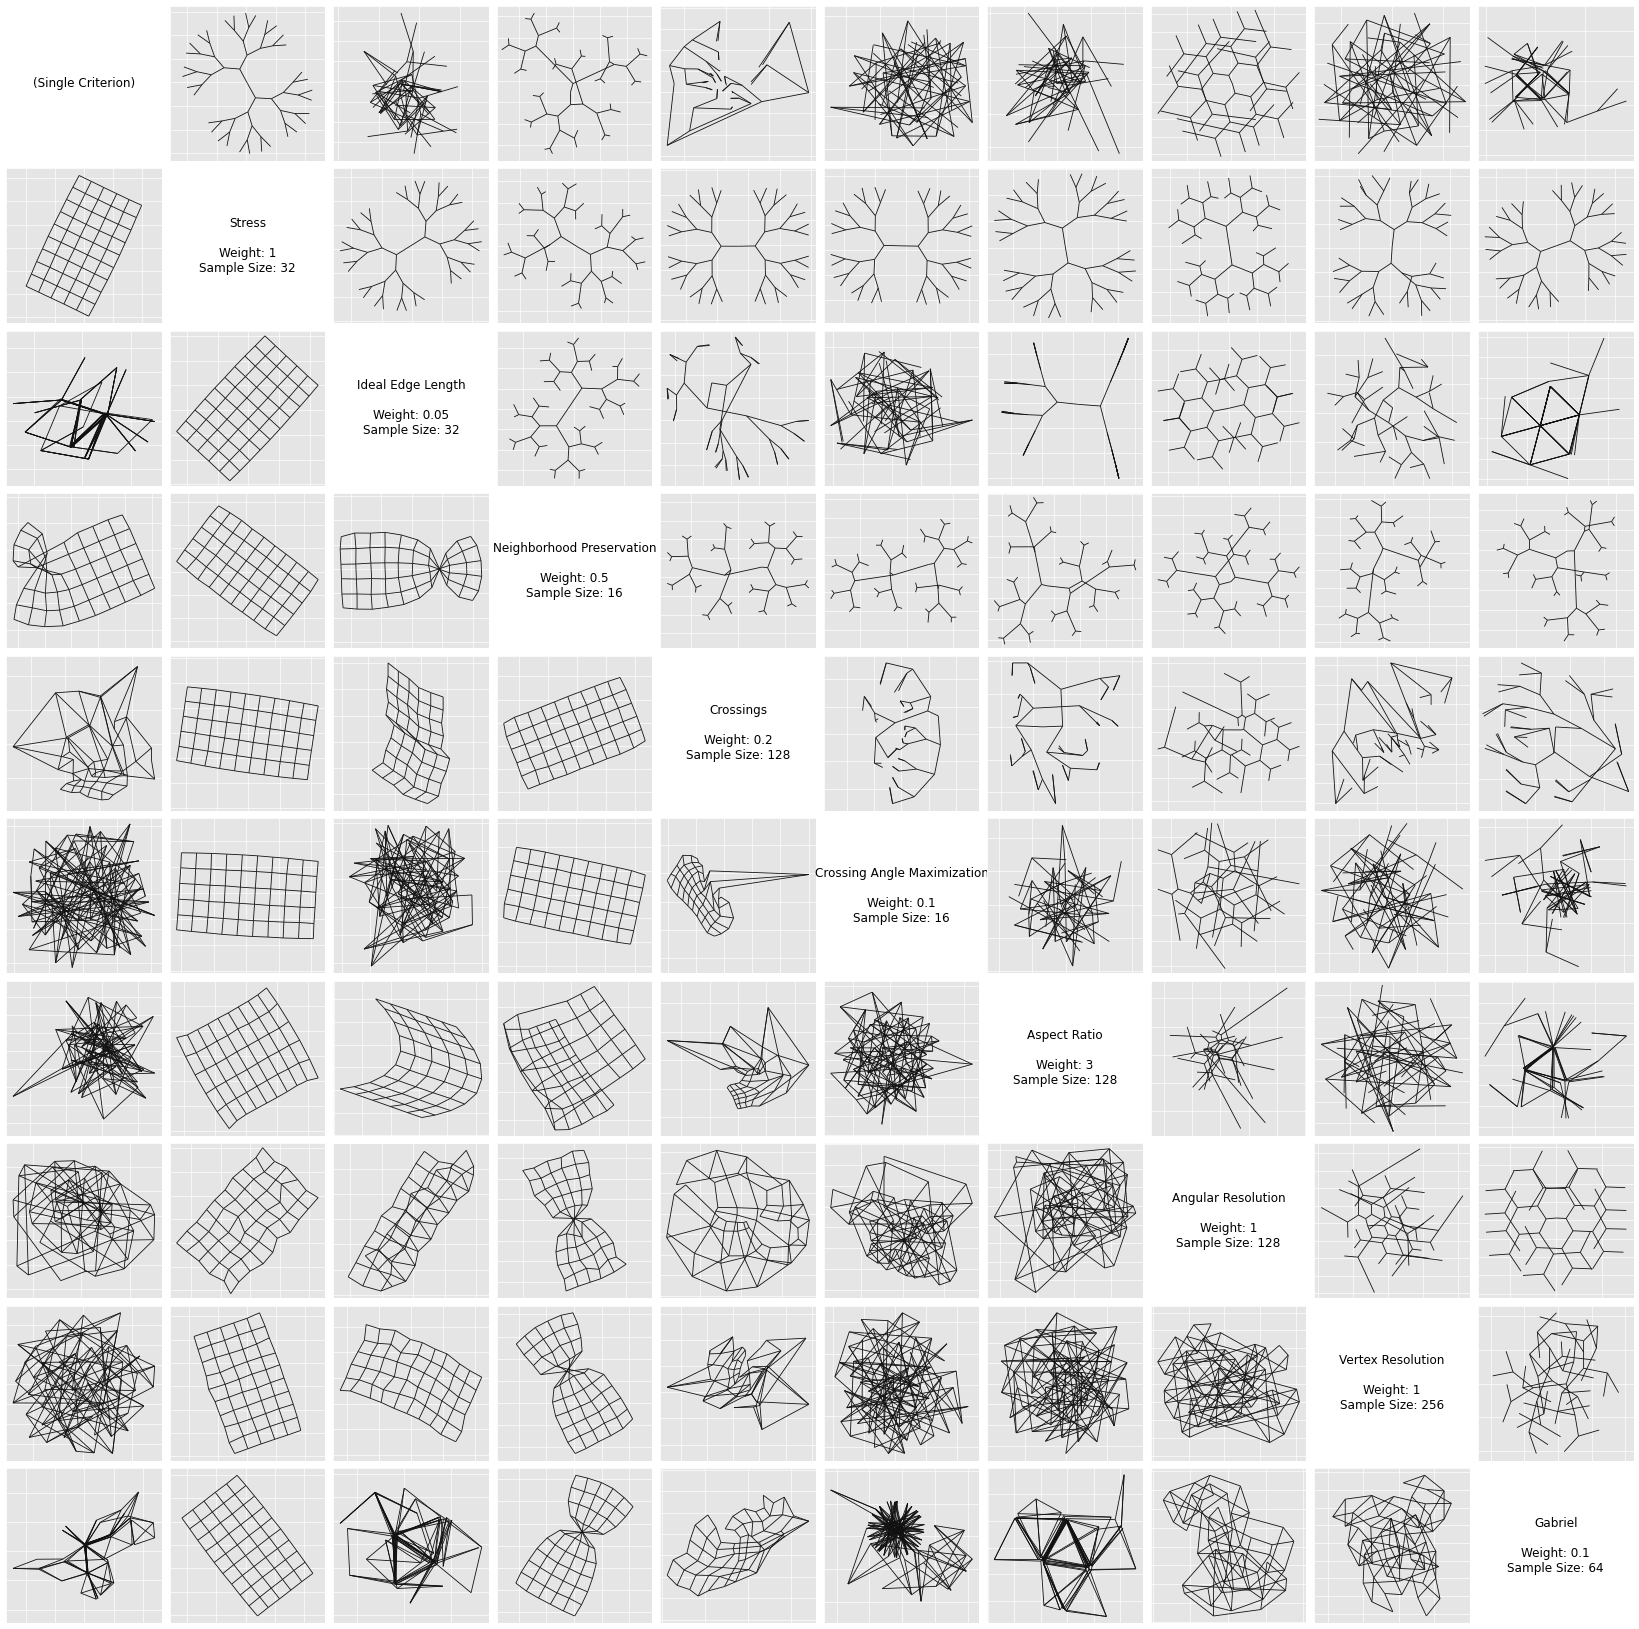

  0%|          | 0/100 [00:00<?, ?it/s]

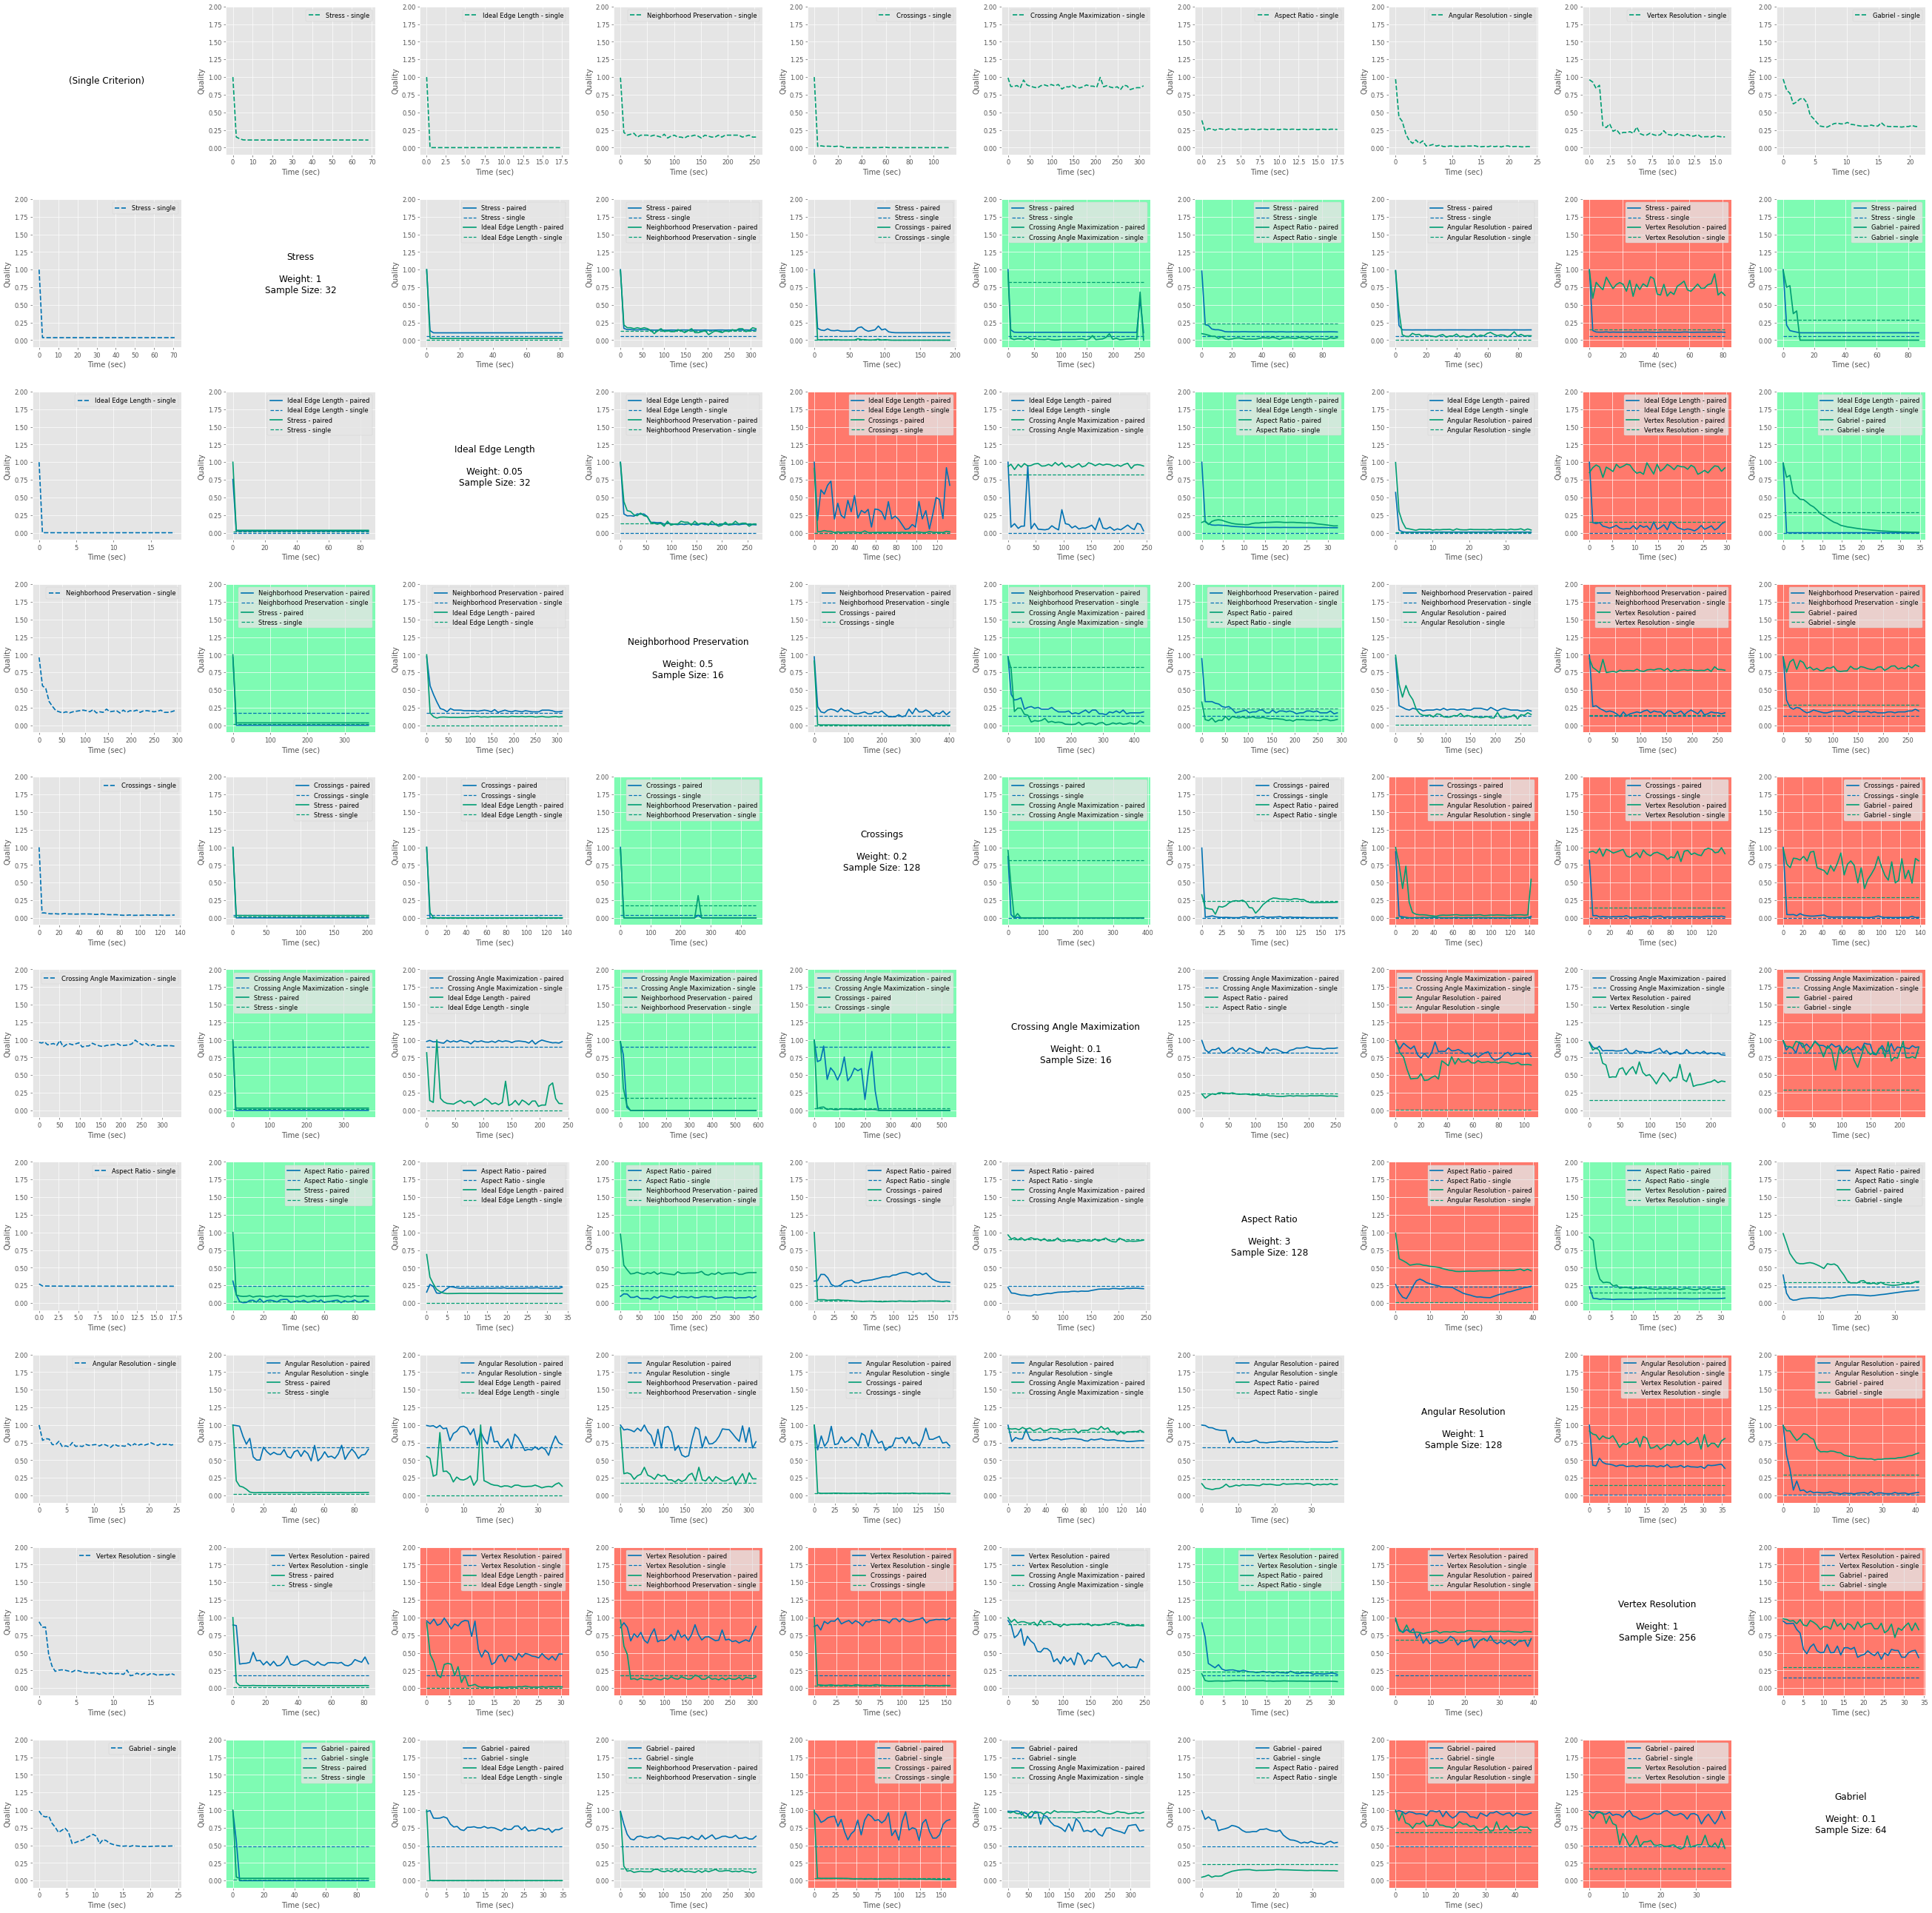

In [17]:
dir_upper = "./analysis/criteria_pairs/tree_2_5-t1635390254"
dir_lower = "./analysis/criteria_pairs/grid_6_10-t1635404907"


# dir_upper = './analysis/criteria_pairs/tree_2_5-t1633999851'
# dir_upper = './analysis/criteria_pairs/tree_2_5-t1634777911'
# dir_upper = './analysis/criteria_pairs/tree_2_5-t1636413236'

# dir_lower = './analysis/criteria_pairs/grid_6_10-t1634797039'
# dir_lower = './analcysis/criteria_pairs/grid_6_10-t1634831625'
# dir_lower = './analysis/criteria_pairs/grid_6_10-t1636404553'
# dir_lower = './analysis/criteria_pairs/grid_6_10-t1636413141'


criteria_all = [
    "",
    "stress",
    "ideal_edge_length",
    "neighborhood_preservation",
    "crossings",
    "crossing_angle_maximization",
    "aspect_ratio",
    "angular_resolution",
    "vertex_resolution",
    "gabriel",
]
n = len(criteria_all)
criteria_pairs = list(
    itertools.product(enumerate(criteria_all), enumerate(criteria_all))
)

for mode in [
    "drawings",
    # "criteria_pairs",
    "learning_curves",
]:

    if mode == "drawings":
        space = 0.05
        figsize = [35, 35]
    elif mode == "learning_curves":
        space = 0.3
        figsize = [55, 55]
    elif mode == "criteria_pairs":
        space = 0.3
        figsize = [45, 45]

    fig = plt.figure(figsize=figsize, dpi=60)
    gs = GridSpec(n, n, wspace=space, hspace=space)

    for (i, ci), (j, cj) in tqdm(criteria_pairs):
        ax = plt.subplot(gs[i, j])

        ## diagonal entries
        if i == j:
            if ci == "":
                show_text(ax, f"(Single Criterion)")
            else:
                show_text(
                    ax,
                    f"{utils.criterion_to_title(ci)}\n"
                    f"\n"
                    f"Weight: {criteria_weights[ci]}\n"
                    f"Sample Size: {sample_sizes[ci]}",
                )
            continue

        ## upper entries
        elif i < j:
            fn = f"{dir_upper}/{ci}-vs-{cj}.pkl"
            fn_1 = f"{dir_upper}/{ci}.pkl"
            fn_2 = f"{dir_upper}/{cj}.pkl"
            if ci == "":
                fn = fn_1 = fn_2 = f"{dir_upper}/{cj}.pkl"
            elif cj == "":
                fn = fn_1 = fn_2 = f"{dir_upper}/{ci}.pkl"

        ## lower entries
        elif i > j:
            fn = f"{dir_lower}/{cj}-vs-{ci}.pkl"
            fn_1 = f"{dir_lower}/{ci}.pkl"
            fn_2 = f"{dir_lower}/{cj}.pkl"
            if ci == "":
                fn = fn_1 = fn_2 = f"{dir_lower}/{cj}.pkl"
            elif cj == "":
                fn = fn_1 = fn_2 = f"{dir_lower}/{ci}.pkl"

        with open(fn, "rb") as f, open(fn_1, "rb") as f1, open(fn_2, "rb") as f2:
            data = pkl.load(f)
            data1 = pkl.load(f1)
            data2 = pkl.load(f2)

        if mode == "drawings":
            draw_graph(data, ax)

        elif mode == "criteria_pairs":
            draw_scatter_plot(data, ci, cj)

        elif mode == "learning_curves":
            draw_learning_curve(data, data1, data2, ci, cj)

    #     plt.savefig(f'{mode}-matrix.pdf', bbox_inches='tight', dpi=120)
    plt.show()

In [ ]:
# c1 = 'stress'
# criteria_all

In [ ]:
# c1, c2 = 'stress', 'angular_resolution'
# c1, c2 = 'stress', 'crossing_angle_maximization'
c1, c2 = "vertex_resolution", "angular_resolution"


bboxes = [0, 0]
fig = plt.figure(figsize=[4.5, 9], dpi=80)
gs = GridSpec(2, 1, wspace=0.01, hspace=0.05)
# for mode in ['drawings', 'criteria_pairs', 'learning_curves']:
for i, mode in enumerate(["drawings", "learning_curves"]):
    print(i)
    ax = plt.subplot(gs[i, 0])

    if criteria_all.index(c1) < criteria_all.index(c2):
        fn = f"{dir_upper}/{c1}-vs-{c2}.pkl"
        fn_1 = f"{dir_upper}/{c1}.pkl"
        fn_2 = f"{dir_upper}/{c2}.pkl"

    elif criteria_all.index(c1) > criteria_all.index(c2):
        fn = f"{dir_upper}/{c2}-vs-{c1}.pkl"
        fn_1 = f"{dir_upper}/{c1}.pkl"
        fn_2 = f"{dir_upper}/{c2}.pkl"

    with open(fn, "rb") as f, open(fn_1, "rb") as f1, open(fn_2, "rb") as f2:
        data = pkl.load(f)
        data1 = pkl.load(f1)
        data2 = pkl.load(f2)

    if mode == "drawings":
        draw_graph(data, ax)

    elif mode == "criteria_pairs":
        draw_scatter_plot(data, c1, c2)

    elif mode == "learning_curves":
        draw_learning_curve(
            data, data1, data2, c1, c2, ylim=[-0.1, 1.5], bg_color=False
        )
#         ax.yaxis.set_label_position('right')
#         plt.ylabel('')

In [ ]:
# ## draw singletons in a separate plot

# # dir_in = './analysis/criteria_pairs/tree_2_5-t1633999851'
# # dir_in = './analysis/criteria_pairs/tree_2_5-t1634777911'
# dir_in = dir_upper
# # dir_in = dir_lower

# graph_str = dir_in.split('/')[-1].split('-t')[0]

# # dir_in = './analysis/criteria_pairs/grid_6_10-t1634190792'

# criteria_all = [
#     'stress',
#     'ideal_edge_length',
#     'neighborhood_preservation',
#     'crossings',
#     'crossing_angle_maximization',
#     'aspect_ratio',
#     'angular_resolution',
#     'vertex_resolution',
#     'gabriel',
# ]
# n = len(criteria_all)


# mode = 'drawings'
# # mode = 'learning_curves'


# if mode == 'drawings':
#     space = 0.05
#     figsize = [35,35/n]
# else:
#     space = 0.3
#     figsize = [40,40/n]

# fig = plt.figure(figsize=figsize, dpi=80)
# gs = GridSpec(1,n, wspace=space, hspace=space)

# for i,c in enumerate(criteria_all):
#     fn = f'{dir_in}/{c}.pkl'
#     with open(fn, 'rb') as f:
#         data = pkl.load(f)

#         ax = plt.subplot(gs[0,i])

#         if mode == 'drawings':
#             ## draw graphs
#             pos = data['pos'].detach().numpy()
#             pos_G = {k:pos[data['k2i'][k]] for k in data['G'].nodes}
#             vis.draw_graph(
#                 data['G'], pos_G, ax=ax,
#                 xlabel=utils.criterion_to_title(c)
#             )
#             ax.xaxis.set_label_position('top')
#             plt.axis('equal')
#             ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

#         elif mode == 'learning_curves':
#             ## plot quality curves
#             t = [r['time'] for r in data['qualities_by_time']]
#             quality_curve = np.array([r['qualities'][c] for r in data['qualities_by_time']])

#             color = 'C0'
#             if c in {'stress', 'crossings', 'ideal_edge_length'}:
#                 quality_curve = quality_curve/quality_curve.max()

#             plt.plot(
#                 t, quality_curve,
#                 '-',
#                 label=f'{utils.criterion_to_title(c)}',
#                 lw=2.0,
#                 color=color,
#             )

#             plt.xlabel('Time (sec)')
#             plt.ylabel('Quality')

#             plt.title(f'{utils.criterion_to_title(c)}')
# #             plt.legend()

#             plt.ylim([-0.1, 1.1])

# plt.savefig(f'{graph_str}-{mode}-plot.pdf', bbox_inches='tight', dpi=120)

## testing reyans hyper cubes

In [ ]:
# import json
# log_dir = 'reyan/log_folder/'
# problematic_files = ['input_11.txt', 'input_18.txt', 'input_26.txt', 'input_27.txt', 'input_28.txt', 'input_48.txt', 'input_56.txt', 'input_63.txt', 'input_70.txt', 'input_71.txt', 'input_73.txt', 'input_74.txt', 'input_75.txt', 'input_76.txt', 'input_93.txt', 'input_94.txt', 'input_95.txt', 'input_101.txt', 'input_102.txt', 'input_103.txt', 'input_108.txt', 'input_109.txt', 'input_110.txt', 'input_115.txt', 'input_116.txt', 'input_117.txt', 'input_118.txt', 'input_120.txt', 'input_121.txt', 'input_122.txt', 'input_123.txt', 'input_124.txt', 'input_125.txt', 'input_126.txt', 'input_127.txt', 'input_128.txt', 'input_129.txt', 'input_134.txt', 'input_137.txt', 'input_138.txt', 'input_139.txt', 'input_140.txt', 'input_146.txt', 'input_147.txt', 'input_148.txt', 'input_153.txt', 'input_154.txt', 'input_155.txt', 'input_157.txt', 'input_160.txt', 'input_161.txt', 'input_162.txt', 'input_163.txt', 'input_164.txt', 'input_166.txt', 'input_167.txt', 'input_168.txt', 'input_169.txt', 'input_170.txt', 'input_171.txt', 'input_172.txt', 'input_173.txt', 'input_174.txt', 'input_179.txt', 'input_183.txt', 'input_184.txt', 'input_185.txt', 'input_191.txt', 'input_192.txt', 'input_193.txt', 'input_198.txt', 'input_199.txt', 'input_200.txt', 'input_202.txt', 'input_205.txt', 'input_206.txt', 'input_208.txt', 'input_209.txt', 'input_211.txt', 'input_212.txt', 'input_213.txt', 'input_214.txt', 'input_215.txt', 'input_216.txt', 'input_217.txt', 'input_218.txt', 'input_219.txt', 'input_224.txt']
# pairs = []
# for fn in problematic_files:
#     with open(log_dir+fn) as f:
#         params = json.load(f)
#         graph_str = f'{params["graph"]} {params["graph_param_1"]}'
#         pairs.append(
#             (tuple(sorted(params['metrics'])),)
#             +(graph_str,fn.split('/')[-1].split('.')[0])
#         )

# # for criteria, graph, fn in natsorted(pairs, key=lambda x:x[-1]):
# for criteria, graph, fn in natsorted(pairs, key=lambda x:x):
#     print(f'{graph}\t{fn:<12} {criteria} ')

In [ ]:
# from pathlib import Path

In [ ]:
# log_dir = 'log_folder/'
# problematic_files = ['input_11.txt', 'input_18.txt', 'input_26.txt', 'input_27.txt', 'input_28.txt', 'input_48.txt', 'input_56.txt', 'input_63.txt', 'input_70.txt', 'input_71.txt', 'input_73.txt', 'input_74.txt', 'input_75.txt', 'input_76.txt', 'input_93.txt', 'input_94.txt', 'input_95.txt', 'input_101.txt', 'input_102.txt', 'input_103.txt', 'input_108.txt', 'input_109.txt', 'input_110.txt', 'input_115.txt', 'input_116.txt', 'input_117.txt', 'input_118.txt', 'input_120.txt', 'input_121.txt', 'input_122.txt', 'input_123.txt', 'input_124.txt', 'input_125.txt', 'input_126.txt', 'input_127.txt', 'input_128.txt', 'input_129.txt', 'input_134.txt', 'input_137.txt', 'input_138.txt', 'input_139.txt', 'input_140.txt', 'input_146.txt', 'input_147.txt', 'input_148.txt', 'input_153.txt', 'input_154.txt', 'input_155.txt', 'input_157.txt', 'input_160.txt', 'input_161.txt', 'input_162.txt', 'input_163.txt', 'input_164.txt', 'input_166.txt', 'input_167.txt', 'input_168.txt', 'input_169.txt', 'input_170.txt', 'input_171.txt', 'input_172.txt', 'input_173.txt', 'input_174.txt', 'input_179.txt', 'input_183.txt', 'input_184.txt', 'input_185.txt', 'input_191.txt', 'input_192.txt', 'input_193.txt', 'input_198.txt', 'input_199.txt', 'input_200.txt', 'input_202.txt', 'input_205.txt', 'input_206.txt', 'input_208.txt', 'input_209.txt', 'input_211.txt', 'input_212.txt', 'input_213.txt', 'input_214.txt', 'input_215.txt', 'input_216.txt', 'input_217.txt', 'input_218.txt', 'input_219.txt', 'input_224.txt']

# for fn in problematic_files:

#     with open(log_dir+fn) as json_file:
#         input_param = json.load(json_file)

#     graph_str = (
#         input_param['graph']
#         + ' '
#         + ' '.join(input_param[k] for k in natsorted(input_param) if k.startswith('graph_param_'))
#     )
#     metrics = input_param['metrics']
#     print(f'='*40)
#     print(f'fn: {fn}')
#     print(f'metrics: {metrics}')
#     print(f'graph: {graph_str}')

#     if Path(input_param["output_file"]).exists():
#         continue

#     print('generating graph', end=' ')
#     if input_param["graph"]=="tree":
#         G = nx.balanced_tree(int(input_param["graph_param_1"]), int(input_param["graph_param_2"]))
#     elif input_param["graph"]=="hypercube":
#         G = nx.hypercube_graph(int(input_param["graph_param_1"]))
#     elif input_param["graph"]=="grid":
#         dim = int(input_param["graph_param_1"])
#         G = nx.grid_graph(dim = [dim, dim])
#     print(f'of {len(G)} nodes')

#     max_iter = 10000
#     criteria_weights_default = {
#         'stress': 4,
#         'ideal_edge_length':1,
#         'neighborhood_preservation':0.5,
#         'crossings':1,
#         'crossing_angle_maximization':0.1,
#         'aspect_ratio':10,
#         'angular_resolution':0.1,
#         'vertex_resolution':1,
#         'gabriel':0.01,
#     }

#     sample_sizes_default = {
#         'stress': 64,
#         'ideal_edge_length': 10,
#         'neighborhood_preservation': 16,
#         'crossings': 10,
#         'crossing_angle_maximization':10,
#         'aspect_ratio': 'full',
#         'angular_resolution': 10,
#         'vertex_resolution': int(len(G)**0.5),
#         'gabriel': 10,
#     }


#     criteria_weights = {}
#     for m in input_param['metrics']:
#         criteria_weights[m] = criteria_weights_default[m]


#     gd = GD2(G)
#     result = gd.optimize(
#         criteria_weights=criteria_weights,
#         sample_sizes=sample_sizes_default,

#         evaluate='all',
#     #     evaluate={'neighborhood_preservation'},
# #         evaluate=set(input_param['metrics']),

#         max_iter=max_iter,
#         evaluate_interval=-1,
#         vis_interval=-1,

#         optimizer_kwargs = dict(lr=1),
#         scheduler_kwargs = dict(verbose=False),
#     )


#     for q,v in result['qualities'].items():
#         print(q,v)

#     return_dict = dict(
#         metric_value=result['qualities'],
#         pos=result['pos'].detach().cpu().tolist(),
#         time=result['runtime']
#     )

#     with open(input_param["output_file"], 'w') as fp:
#         json.dump(return_dict, fp)


#     ## vis for debugging
#     pos = gd.pos.detach().numpy()
#     pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
#     vis.plot(
#         gd.G, pos_G,
#         gd.loss_curve,
#         result['iter'], result['runtime'],
#         edge=True, show=True, save=False
#     )

## Animation

In [ ]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# if type(xPath) == list:
#     xPath = np.stack(xPath)

# padding = 0.1

# fig, ax = plt.subplots()
# scatter = plt.scatter([0], [0], s=10)
# lc = mc.LineCollection([], linewidths=1)
# ax.add_collection(lc)

# xlim = [np.min(xPath[:,:,0]),np.max(xPath[:,:,0])]
# ylim = [np.min(xPath[:,:,1]),np.max(xPath[:,:,1])]
# xlim = [xlim[0]-padding*(xlim[1]-xlim[0]), xlim[1]+padding*(xlim[1]-xlim[0])]
# ylim = [ylim[0]-padding*(ylim[1]-ylim[0]), ylim[1]+padding*(ylim[1]-ylim[0])]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

# def init():
#     return scatter,lc

# def update(frame):
#     xy = xPath[frame]
#     scatter.set_offsets(xy)
#     segs = [[xy[k2i[k0]], xy[k2i[k1]]] for k0,k1 in G.edges]
#     lc.set_segments(segs)
#     return scatter,lc

# anim = FuncAnimation(
#     fig,
#     update,
#     frames=range(0,len(xPath),1),
#     init_func=init,
#     interval=1000.0/20,
#     blit=True)

# HTML(anim.to_jshtml())

In [ ]:
# x = pos.detach().cpu().numpy()
# pos_i = {k: x[k2i[k], :2] for k in G.nodes}
# vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)

## animation

In [ ]:
# # Create a gif from images in fig/
# #
# frames = []
# imgs = natsorted(glob('fig/*.png'))

# for img in imgs:
#     new_frame = Image.open(img)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=100, loop=0)